In [2]:
a='predict patient has diabetes,'
a.title()

'Predict Patient Has Diabetes,'

Disclaimer: This dataset is originally from the National Institute of Diabetes and Digestive
and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or
not a patient has diabetes, based on certain diagnostic measurements included in the
dataset.

Dataset description: It has 768 rows of data.<br>
1. Pregnancies– Number of times pregnant<br>
2. Glucose– Plasma glucose concentration a 2 hours in an oral glucose tolerance test<br>
3. BloodPressure– Diastolic blood pressure (mm Hg)<br>
4. SkinThickness– Triceps skinfold thickness (mm)<br>
5. Insulin- 2-Hour serum insulin (mu U/ml)<br>
6. BMI – Body mass index (weight in kg/ (height in m)^2)<br>
7. DiabetesPedigreeFunction– Diabetes pedigree function<br>
8. Age- Age (years)<br>
9. Outcome – Class variable (0 or 1) 268 of 768 are 1, the others are 0<br>

Task: You will use the Pima Indian diabetes dataset. The dataset corresponds to a classification
problem on which you need to make predictions on the basis of whether a person is to suffer
diabetes given the 8 features in the dataset. You are asked to use this data to build a XGBoost
Classifier model using scikit-learn. Tune the parameters using Grid Search and Randomized Search
strategies.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('files/diabetes.csv')
df=data.copy()
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isna().sum().sum()

0

In [6]:
for i in df.columns:
    print(i,data[i].nunique())

Pregnancies 17
Glucose 136
BloodPressure 47
SkinThickness 51
Insulin 186
BMI 248
DiabetesPedigreeFunction 517
Age 52
Outcome 2


Text(0.5, 1.0, "Correlatyuion of the variables to 'Outcome' feature")

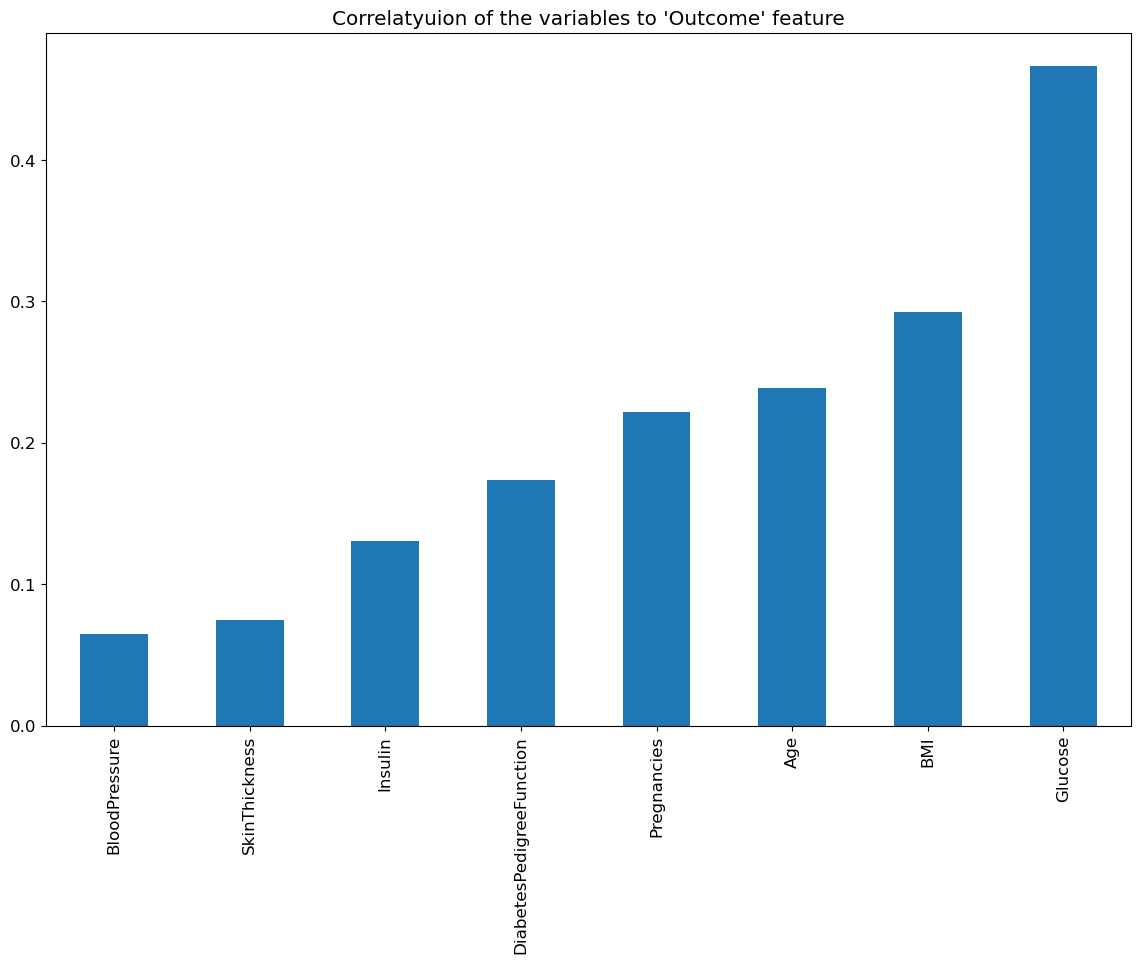

In [7]:
plt.figure(figsize=(14,9))
plt.rcParams['font.size']=12
data.corr()['Outcome'].sort_values().drop('Outcome').plot(kind='bar')
plt.title("Correlatyuion of the variables to 'Outcome' feature")

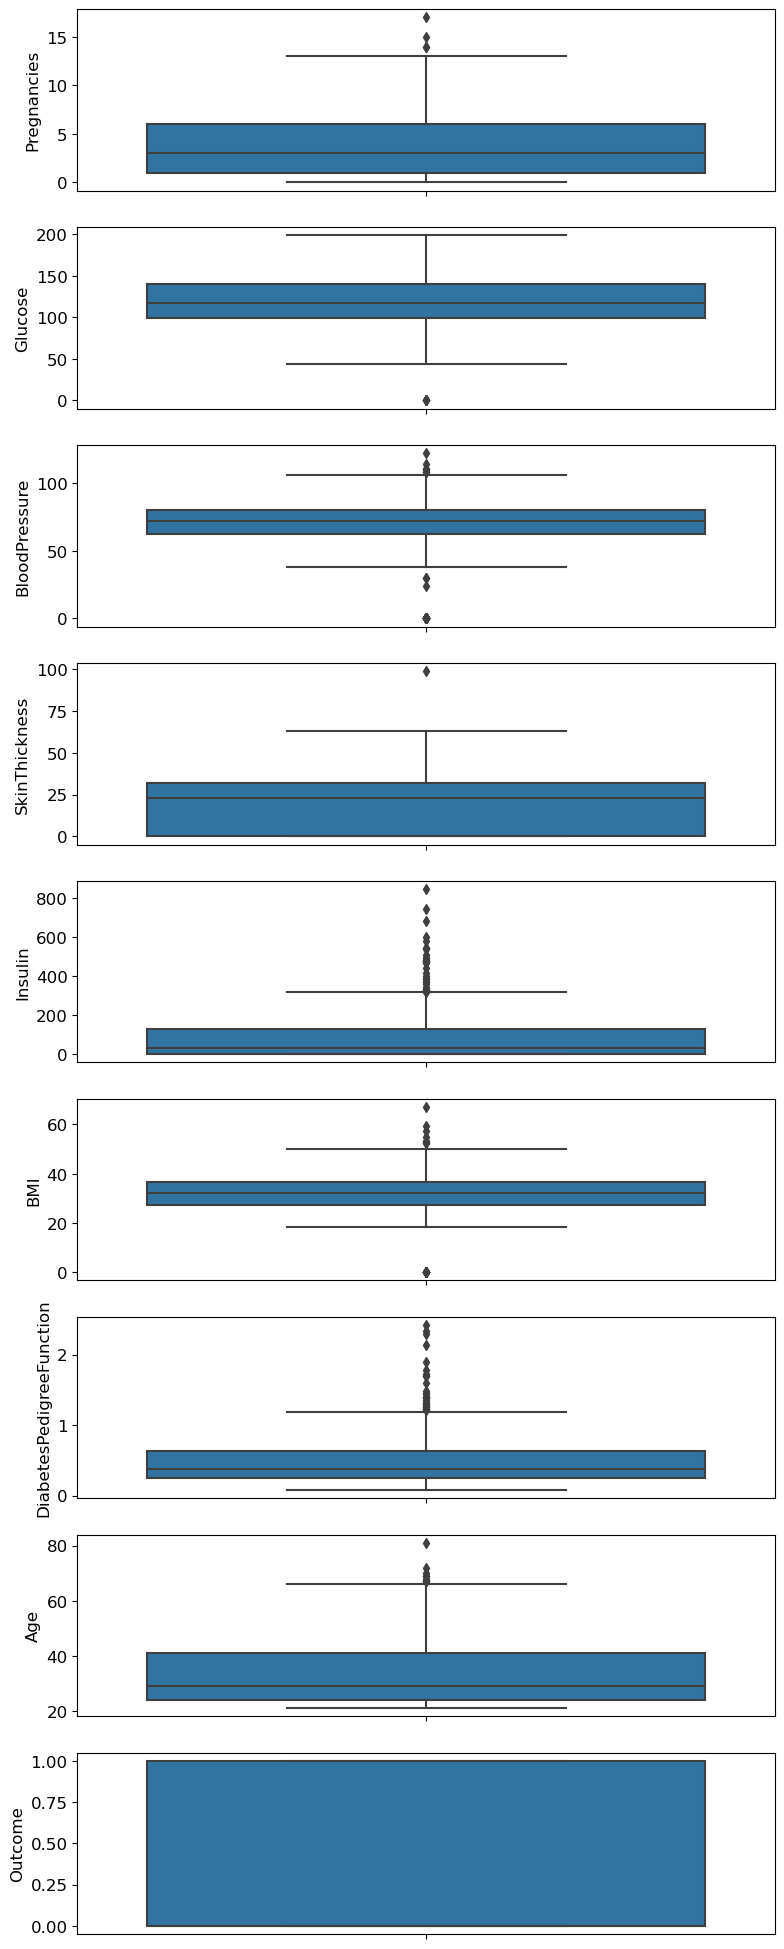

In [8]:
column_names=df.columns
fig,axes =plt.subplots(nrows=len(column_names),figsize=(9,25))

for i in range (len(column_names)):
    sns.boxplot(ax=axes[i],y=column_names[i],data=df)

In [9]:
scaler=RobustScaler()
X_columns=df.columns[:-1]
X=scaler.fit_transform(df.drop('Outcome',axis=1))
X=pd.DataFrame(X,columns=X_columns)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.751515,0.000000,0.37500,-0.239686,0.172043,0.665359,1.235294
1,-0.4,-0.775758,-0.333333,0.18750,-0.239686,-0.580645,-0.056209,0.117647
2,1.0,1.600000,-0.444444,-0.71875,-0.239686,-0.935484,0.783007,0.176471
3,-0.4,-0.678788,-0.333333,0.00000,0.499018,-0.419355,-0.537255,-0.470588
4,-0.6,0.484848,-1.777778,0.37500,1.080550,1.193548,5.007843,0.235294


In [10]:
y=df['Outcome']

In [11]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=0, stratify=y)

### Model

In [12]:
model=XGBClassifier(random_state=2)

In [13]:
y_pred=model.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       100
           1       0.71      0.63      0.67        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.78       154



### GridSearchCV

In [14]:
xgb_param={'learning_rate': [0.1,0.2,0.3,0.4,0.5],
              'max_depth': np.arange(2,13),
              'subsample': np.arange(0.1,0.6,step=0.1)}

In [15]:
xgb_grid = GridSearchCV(estimator=model, 
                        param_grid=xgb_param,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1,
                        return_train_score=True)

In [16]:
xgb_fit=xgb_grid.fit(X_train,y_train)


In [17]:
cv_results_xgb = pd.DataFrame.from_dict(xgb_fit.cv_results_)
cv_results_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.754926,0.053915,0.007843,0.007843,0.1,2,0.1,"{'learning_rate': 0.1, 'max_depth': 2, 'subsam...",0.774194,0.725806,...,0.806159,0.788043,0.810127,0.788427,0.783002,0.810127,0.790235,0.804702,0.795691,0.010261
1,0.192628,0.204762,0.008063,0.005380,0.1,2,0.2,"{'learning_rate': 0.1, 'max_depth': 2, 'subsam...",0.774194,0.677419,...,0.827899,0.815217,0.822785,0.797468,0.811935,0.820976,0.828210,0.822785,0.818677,0.008749
2,0.096776,0.012225,0.001395,0.002259,0.1,2,0.3,"{'learning_rate': 0.1, 'max_depth': 2, 'subsam...",0.725806,0.693548,...,0.836957,0.820652,0.824593,0.813743,0.817360,0.815552,0.822785,0.833635,0.825013,0.007924
3,0.100787,0.014399,0.004629,0.005934,0.1,2,0.4,"{'learning_rate': 0.1, 'max_depth': 2, 'subsam...",0.758065,0.677419,...,0.840580,0.824275,0.837251,0.826401,0.826401,0.842676,0.833635,0.837251,0.834963,0.006586
4,0.100027,0.011614,0.005322,0.004026,0.1,2,0.5,"{'learning_rate': 0.1, 'max_depth': 2, 'subsam...",0.758065,0.677419,...,0.851449,0.844203,0.849910,0.840868,0.849910,0.842676,0.846293,0.855335,0.845999,0.005194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0.123037,0.016988,0.008424,0.006379,0.5,12,0.1,"{'learning_rate': 0.5, 'max_depth': 12, 'subsa...",0.741935,0.693548,...,0.800725,0.768116,0.808318,0.783002,0.804702,0.795660,0.784810,0.806510,0.793336,0.013361
271,0.151379,0.012556,0.011346,0.007626,0.5,12,0.2,"{'learning_rate': 0.5, 'max_depth': 12, 'subsa...",0.645161,0.645161,...,0.907609,0.911232,0.929476,0.873418,0.886076,0.913201,0.893309,0.898734,0.901016,0.015076
272,0.194484,0.011371,0.006311,0.003632,0.5,12,0.3,"{'learning_rate': 0.5, 'max_depth': 12, 'subsa...",0.693548,0.725806,...,0.980072,0.972826,0.981917,0.980108,0.981917,0.974684,0.983725,0.971067,0.978284,0.003967
273,0.221761,0.009819,0.007472,0.005590,0.5,12,0.4,"{'learning_rate': 0.5, 'max_depth': 12, 'subsa...",0.693548,0.693548,...,0.998188,0.998188,0.992767,0.998192,0.996383,1.000000,0.996383,0.998192,0.997648,0.001989


In [18]:
xgb_fit.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.1}

In [20]:
model=XGBClassifier(random_state=2,learning_rate= 0.1, max_depth= 2, subsample= 0.1)
y_pred=model.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.61      0.66        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



### Randomized Search

In [23]:
model=XGBClassifier(random_state=2)
y_pred=model.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       100
           1       0.71      0.63      0.67        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.78       154



In [24]:
xgb_param={'learning_rate': [0.1,0.05,0.03,0.07],
              'max_depth': [1,2,3,4,5],
              'subsample': [0.1,0.05,0.03,0.07]}

In [26]:
xgb_grid = RandomizedSearchCV(estimator=model, 
                        param_distributions=xgb_param,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1,
                        return_train_score=True)

In [27]:
xgb_fit=xgb_grid.fit(X_train,y_train)


In [28]:
cv_results_xgb = pd.DataFrame.from_dict(xgb_fit.cv_results_)
cv_results_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.871266,0.037107,0.003126,0.006252,0.05,2,0.07,"{'subsample': 0.05, 'max_depth': 2, 'learning_...",0.790323,0.790323,...,0.778986,0.766304,0.783002,0.770344,0.770344,0.768535,0.777577,0.784810,0.775063,0.007127
1,0.227293,0.263960,0.004867,0.004834,0.03,5,0.07,"{'subsample': 0.03, 'max_depth': 5, 'learning_...",0.741935,0.741935,...,0.757246,0.748188,0.772152,0.757685,0.757685,0.777577,0.763110,0.775769,0.764021,0.009218
2,0.081062,0.006079,0.006337,0.002830,0.1,2,0.05,"{'subsample': 0.1, 'max_depth': 2, 'learning_r...",0.774194,0.790323,...,0.788043,0.786232,0.808318,0.788427,0.779385,0.790235,0.775769,0.799277,0.787366,0.010177
3,0.098277,0.010035,0.007536,0.007494,0.1,5,0.03,"{'subsample': 0.1, 'max_depth': 5, 'learning_r...",0.774194,0.758065,...,0.778986,0.778986,0.813743,0.786618,0.784810,0.804702,0.786618,0.801085,0.790620,0.011296
4,0.078652,0.008627,0.005896,0.005795,0.05,4,0.1,"{'subsample': 0.05, 'max_depth': 4, 'learning_...",0.774194,0.758065,...,0.780797,0.775362,0.775769,0.759494,0.781193,0.764919,0.779385,0.801085,0.777597,0.010667
5,0.091169,0.007773,0.003079,0.004415,0.07,5,0.07,"{'subsample': 0.07, 'max_depth': 5, 'learning_...",0.790323,0.758065,...,0.791667,0.773551,0.788427,0.790235,0.784810,0.790235,0.792043,0.788427,0.786824,0.005205
6,0.081364,0.017123,0.006001,0.006728,0.05,5,0.1,"{'subsample': 0.05, 'max_depth': 5, 'learning_...",0.774194,0.758065,...,0.780797,0.775362,0.775769,0.759494,0.781193,0.764919,0.779385,0.801085,0.777597,0.010667
7,0.074459,0.005431,0.002771,0.004913,0.05,3,0.05,"{'subsample': 0.05, 'max_depth': 3, 'learning_...",0.741935,0.790323,...,0.768116,0.768116,0.770344,0.770344,0.779385,0.773960,0.777577,0.790235,0.773250,0.008285
8,0.075046,0.006974,0.004497,0.005978,0.07,2,0.1,"{'subsample': 0.07, 'max_depth': 2, 'learning_...",0.790323,0.758065,...,0.795290,0.782609,0.804702,0.801085,0.783002,0.795660,0.802893,0.795660,0.791525,0.010163
9,0.058512,0.010816,0.003954,0.004679,0.03,1,0.03,"{'subsample': 0.03, 'max_depth': 1, 'learning_...",0.758065,0.758065,...,0.755435,0.740942,0.772152,0.755877,0.764919,0.754069,0.754069,0.763110,0.756238,0.009768


In [29]:
xgb_fit.best_params_

{'subsample': 0.07, 'max_depth': 5, 'learning_rate': 0.07}

In [30]:
model=XGBClassifier(random_state=2,learning_rate= 0.07, max_depth= 5, subsample=  0.07)
y_pred=model.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       100
           1       0.73      0.67      0.70        54

    accuracy                           0.80       154
   macro avg       0.78      0.77      0.77       154
weighted avg       0.80      0.80      0.80       154

